In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# PCA module
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
#import xgboost as xgb
#from xgboost import plot_importance, plot_tree
from sklearn.preprocessing import OneHotEncoder
import datetime

In [2]:
#r_dir = r'../raw_data/'
#c_dir = r'../cleaned_data/'

In [3]:
Features = pd.read_csv("TS_2018.csv")
Features['tpep_pickup_datetime'] = pd.to_datetime(Features['tpep_pickup_datetime'],format ='%Y-%m-%d %H:%M:%S')

In [4]:
Features = Features.drop(columns = 'Unnamed: 0')

In [5]:
Features.head()

,tpep_pickup_datetime,DOM,DOW,HOD,bad_weather,is_holiday,lag1,lag2,lag3,lag4,...,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,trip_count
0,2018-09-02 00:00:00,2,6,0,0,0,480,672,398,378,...,150,115,80,76,166,156,181,282,441,351
1,2018-09-02 01:00:00,2,6,1,0,0,351,480,672,398,...,259,150,115,80,76,166,156,181,282,260
2,2018-09-02 02:00:00,2,6,2,0,0,260,351,480,672,...,341,259,150,115,80,76,166,156,181,173
3,2018-09-02 03:00:00,2,6,3,0,0,173,260,351,480,...,363,341,259,150,115,80,76,166,156,148
4,2018-09-02 04:00:00,2,6,4,0,0,148,173,260,351,...,358,363,341,259,150,115,80,76,166,154


In [6]:
# One hot encoding 
cat_columns = ['DOW','DOM','HOD']
Features_onehot =  pd.get_dummies(Features,prefix_sep="__",columns=cat_columns)
Features_onehot.shape

(2904, 90)

In [7]:
# Train validation test split
test_df = Features_onehot.iloc[2160:,:]
test_dfx = test_df.drop(['trip_count','tpep_pickup_datetime'],axis=1)
test_dfy = test_df.trip_count

train_df = Features_onehot.iloc[0:1728,:]
train_dfx = train_df.drop(['trip_count','tpep_pickup_datetime'],axis=1)
train_dfy = train_df.trip_count

valid_df = Features_onehot.iloc[1728:2160,:]
valid_dfx = valid_df.drop(['trip_count','tpep_pickup_datetime'],axis=1)
valid_dfy = valid_df.trip_count

In [8]:
# Normalization - MinMaxScaler

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#train_df_scaled = pd.DataFrame(scaler.fit_transform(train_df), columns= train_df.columns)
#valid_df_scaled = pd.DataFrame(scaler.fit_transform(valid_df), columns= valid_df.columns)
#test_df_scaled = pd.DataFrame(scaler.fit_transform(test_df), columns= test_df.columns)

train_dfx_scaled = pd.DataFrame(scaler.fit_transform(train_dfx), columns= train_dfx.columns)
valid_dfx_scaled = pd.DataFrame(scaler.fit_transform(valid_dfx), columns= valid_dfx.columns)
test_dfx_scaled = pd.DataFrame(scaler.fit_transform(test_dfx), columns= test_dfx.columns)

In [10]:
#new dataframe
train_dfx_scaled['trip_count'] = train_df['trip_count']
valid_dfx_scaled['trip_count'] = valid_df['trip_count'].reset_index(drop = True)
test_dfx_scaled['trip_count'] = test_df['trip_count'].reset_index(drop = True)

In [11]:
# Linear Regression
lm_train = smf.ols(formula = 'trip_count ~ C(bad_weather)+C(is_holiday)+'+'+'.join(train_dfx_scaled.columns[2:88]), data = train_dfx_scaled).fit()
print(lm_train.summary())

                            OLS Regression Results                            
Dep. Variable:             trip_count   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     243.8
Date:                Sat, 14 Dec 2019   Prob (F-statistic):               0.00
Time:                        12:42:02   Log-Likelihood:                -9324.7
No. Observations:                1728   AIC:                         1.882e+04
Df Residuals:                    1642   BIC:                         1.929e+04
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                95.25

In [12]:
lmy = lm_train.predict(valid_dfx_scaled)
R2_OS = r2_score(valid_dfx_scaled.trip_count,lmy)
MAE = mean_absolute_error(valid_dfx_scaled.trip_count,lmy)
print('The validation sample R2 is',R2_OS)
print('The validation mean absolute error is',MAE)

The validation sample R2 is 0.8892176612328473
The validation mean absolute error is 47.154885742681294


In [13]:
lmy_t = lm_train.predict(test_dfx_scaled)
R2_OS = r2_score(test_dfx_scaled.trip_count,lmy_t)
MAE = mean_absolute_error(test_dfx_scaled.trip_count,lmy_t)
print('The test sample R2 is',R2_OS)
print('The test mean absolute error is',MAE)

The test sample R2 is 0.8510033868193867
The test mean absolute error is 56.07664464726189


In [14]:
n=len(train_dfx.columns[2:88])

In [15]:
# The regression function based on the feature selection
def AdjR2(flag):
    
    #1--feature included
    #0--feature excluded
    
    formstr='trip_count~C(bad_weather)+C(is_holiday)'
    for i in range(len(flag)):
        if flag[i]==1:
            formstr += '+'+'+'.join(train_dfx_scaled.columns[i+2:i+3])
    lm = smf.ols(formula = formstr, data = train_dfx_scaled).fit()
    lmy = lm.predict(valid_dfx_scaled)
    y_err = lmy-valid_dfx_scaled.trip_count
    y_norm = valid_dfx_scaled.trip_count - sum(valid_dfx_scaled.trip_count)/len(valid_dfx_scaled.trip_count)
    # Adjusted R^2
    R2_OS = 1 - y_err.dot(y_err) / y_norm.dot(y_norm) * (n-3-1) / (n-3-sum(flag)-1)
    return lm, R2_OS

In [16]:
# Feature selection based on the p-values
def DropP(threshold = 1):
    flag_p = (AdjR2([1]*(n-3))[0]).pvalues < threshold
    print('Validation R^2 is %f'%AdjR2(flag_p)[1])
    print(AdjR2(flag_p)[0].summary())

In [17]:
DropP(0.05)

Validation R^2 is 0.789530
                            OLS Regression Results                            
Dep. Variable:             trip_count   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     472.1
Date:                Sat, 14 Dec 2019   Prob (F-statistic):               0.00
Time:                        12:42:03   Log-Likelihood:                -9483.1
No. Observations:                1728   AIC:                         1.904e+04
Df Residuals:                    1690   BIC:                         1.925e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Int

In [18]:
#find best feature selection that maximize validation adjusted R2
def FindBestI():
    flag = np.zeros(n)
    r2max = 0             
    while True:
        flag_mat = np.maximum(np.eye(n),flag) 
        
        r2 = np.apply_along_axis(AdjR2,1,flag_mat)[:,1]  
        temp = r2.max()
        if temp > r2max:
            r2max = temp
            flag = flag_mat[r2.argmax()]  
        else:
            break                         
    return flag

flag = FindBestI()             

In [19]:
lm_best,r2_best = AdjR2(flag)

col = ['intercept'] + list(train_dfx_scaled.columns[:88])

ix = [col[i+3] for i in range(n) if flag[i]==1]

b = pd.DataFrame({'Pvalues':AdjR2([1]*n)[0].pvalues, 'Keeper':col})

c = 'forestgreen'

def highlight_pval(val):
    color = c if val in ix else 'white'
    return 'background-color: %s'%color

b.style.applymap(highlight_pval, subset=['Keeper']).\
    bar(subset = ['Pvalues'], color=c)

,Pvalues,Keeper
Intercept,3.05789e-10,intercept
C(bad_weather)[T.1.0],0.23172,bad_weather
C(is_holiday)[T.1.0],0.327893,is_holiday
lag1,1.54624e-129,lag1
lag2,0.20847,lag2
lag3,0.000557593,lag3
lag4,0.900678,lag4
lag5,0.220166,lag5
lag6,0.0813465,lag6
lag7,8.61124e-05,lag7


In [20]:
#features that best fit
print('Validation R^2 is %f'%r2_best)
print(lm_best.summary())

Validation R^2 is 0.865425
                            OLS Regression Results                            
Dep. Variable:             trip_count   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     1079.
Date:                Sat, 14 Dec 2019   Prob (F-statistic):               0.00
Time:                        12:43:11   Log-Likelihood:                -9502.3
No. Observations:                1728   AIC:                         1.904e+04
Df Residuals:                    1711   BIC:                         1.913e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Int

In [21]:
lmy_v = lm_best.predict(valid_dfx_scaled)
R2_OS = r2_score(valid_dfx_scaled.trip_count,lmy_v)
MAE = mean_absolute_error(valid_dfx_scaled.trip_count,lmy_v)
print('The validation sample R2 is',R2_OS)
print('The validation mean absolute error is',MAE)

The validation sample R2 is 0.8884010356789588
The validation mean absolute error is 48.394393816369856


In [22]:
lmy_te = lm_best.predict(test_dfx_scaled)
R2_OS = r2_score(test_dfx_scaled.trip_count,lmy_te)
MAE = mean_absolute_error(test_dfx_scaled.trip_count,lmy_te)
print('The test sample R2 is',R2_OS)
print('The test mean absolute error is',MAE)

The test sample R2 is 0.8356725992763478
The test mean absolute error is 58.74344102427991


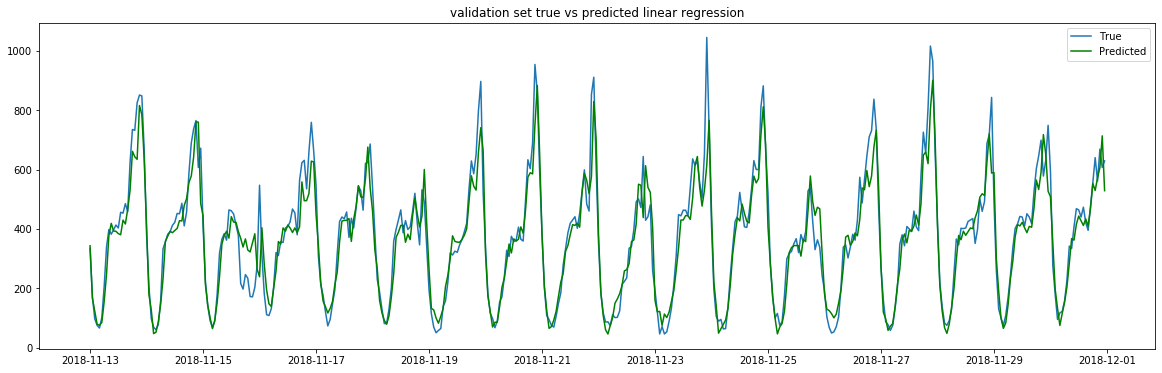

In [24]:
plt.figure(figsize=(20,6))
plt.plot(valid_df['tpep_pickup_datetime'],valid_dfx_scaled['trip_count'],label='True')
plt.plot(valid_df['tpep_pickup_datetime'],lmy_v, color='green',label='Predicted')
plt.title('validation set true vs predicted linear regression')
plt.legend()
plt.show()

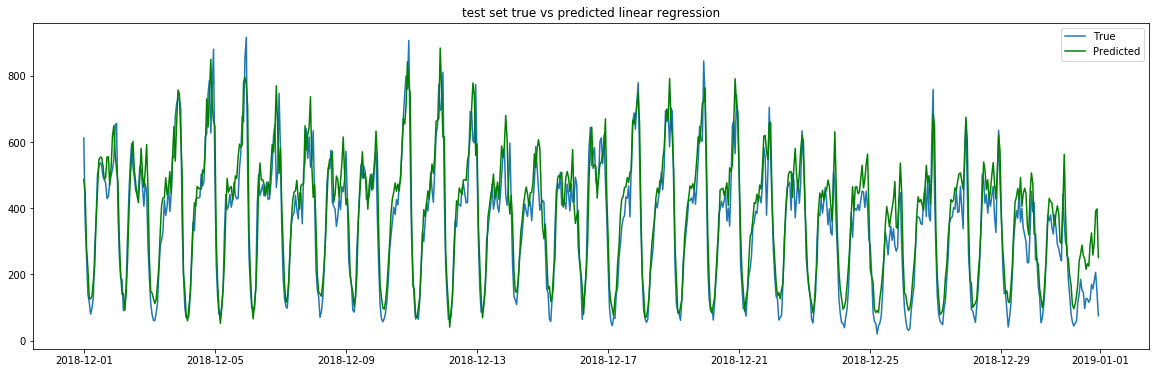

In [25]:
plt.figure(figsize=(20,6))
plt.plot(test_df['tpep_pickup_datetime'],test_dfx_scaled['trip_count'],label='True')
plt.plot(test_df['tpep_pickup_datetime'],lmy_te, color='green',label='Predicted')
plt.title('test set true vs predicted linear regression')
plt.legend()
plt.show()